# ML Intern Task: 
# Hyperspectral Imaging Data Analysis and DON Concentration Prediction

This notebook demonstrates an end-to-end workflow for processing a hyperspectral corn dataset. We will:

- **Explore and preprocess the data:** Handle missing values, normalize features, and visualize spectral bands.
- **Perform dimensionality reduction:** Using PCA and visualizing the principal components.
- **Train multiple machine learning models** to predict DON concentration including:
  - A Feed-Forward Neural Network (baseline)
  - A 1D CNN
  - An LSTM network
  - An XGBoost regressor
  - A Graph Neural Network (GNN) using Spektral

Each model is evaluated using regression metrics (MAE, RMSE, R²) and visualization of actual vs. predicted values.

Ensure that the CSV file (`TASK-ML-INTERN.csv`) is available in the same directory before running the notebook.

In [72]:
 import os
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt 
import seaborn as sns
 import streamlit as st
 import joblib
 from sklearn.preprocessing import MinMaxScaler
 from sklearn.preprocessing import StandardScaler
 from sklearn.decomposition import PCA
 from sklearn.model_selection import train_test_split
 from sklearn.ensemble import RandomForestRegressor
 from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
 import tensorflow as tf
 from tensorflow.keras.models import Sequential, Model
 from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten, LSTM
 from tensorflow.keras.callbacks import EarlyStopping
 from spektral.layers import GCNConv
 import scipy.sparse as sp
 from sklearn.neighbors import kneighbors_graph
 from spektral.utils import normalized_adjacency
 # XGBoost
 import xgboost as xgb
 %matplotlib inline
 sns.set(style="whitegrid")

## Data Loading and Preprocessing
In the hyperspectral dataset:
 - We check for missing values (and impute them using the column mean)
 - Identify the target variable (DON concentration)
 - Normalize the spectral features.

In [73]:
df=pd.read_csv("TASK-ML-INTERN.csv")

In [74]:
df

,hsi_id,0,1,2,3,4,5,6,7,8,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
0,imagoai_corn_0,0.416181,0.396844,0.408985,0.372865,0.385293,0.365390,0.355226,0.343350,0.344837,...,0.710280,0.717482,0.715078,0.705379,0.696691,0.692793,0.711369,0.697679,0.704520,1100.0
1,imagoai_corn_1,0.415797,0.402956,0.402564,0.396014,0.397192,0.389634,0.375671,0.363689,0.373883,...,0.684011,0.697271,0.701995,0.696077,0.701012,0.677418,0.696921,0.696544,0.689054,1000.0
2,imagoai_corn_2,0.389023,0.371206,0.373098,0.373872,0.361056,0.349709,0.333882,0.330841,0.328925,...,0.683054,0.669286,0.663179,0.676165,0.676591,0.655951,0.658945,0.670989,0.665176,1300.0
3,imagoai_corn_3,0.468837,0.473255,0.462949,0.459335,0.461672,0.459824,0.458194,0.427737,0.415360,...,0.742782,0.730801,0.736787,0.730044,0.751437,0.738497,0.742446,0.754657,0.733474,1300.0
4,imagoai_corn_4,0.483352,0.487274,0.469153,0.487648,0.464026,0.451152,0.458229,0.440782,0.426193,...,0.770227,0.773013,0.761431,0.763488,0.762473,0.744012,0.775486,0.760431,0.751988,220.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,imagoai_corn_495,0.478140,0.444033,0.442120,0.437473,0.428672,0.413238,0.417758,0.420388,0.413290,...,0.747858,0.730535,0.716969,0.739297,0.724827,0.720484,0.740626,0.740116,0.721839,1200.0
496,imagoai_corn_496,0.409367,0.394941,0.380236,0.375340,0.346122,0.354650,0.361170,0.342974,0.352137,...,0.670232,0.659045,0.661587,0.658422,0.644254,0.646479,0.656779,0.646700,0.646733,0.0
497,imagoai_corn_497,0.486526,0.501372,0.500175,0.508139,0.489411,0.457311,0.462321,0.462927,0.442647,...,0.787532,0.780347,0.768362,0.771411,0.770919,0.761464,0.770314,0.763324,0.797187,0.0
498,imagoai_corn_498,0.464595,0.498822,0.489077,0.453381,0.487636,0.461950,0.461671,0.447362,0.451952,...,0.739432,0.759722,0.752118,0.761910,0.761111,0.730431,0.753545,0.749619,0.756383,0.0


In [75]:
# Drop 'hsi_id' column (not useful for modeling)
df.drop(columns=['hsi_id'], inplace=True)

print("Dataset shape:", df.shape)
print("Dataset columns:", df.columns.tolist())

Dataset shape: (500, 449)
Dataset columns: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '1

In [76]:
X = df.iloc[:, :-1]  # Spectral Features
y = df["vomitoxin_ppb"]  # Target Variable (DON concentration)
df_clean = df.copy()

In [77]:
# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())



Missing values per column:
 0                0
1                0
2                0
3                0
4                0
                ..
444              0
445              0
446              0
447              0
vomitoxin_ppb    0
Length: 449, dtype: int64


In [78]:
# Impute missing values with the column mean
df.fillna(df.mean(), inplace=True)

In [79]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,439,440,441,442,443,444,445,446,447,vomitoxin_ppb
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.443118,0.440761,0.433814,0.426122,0.418990,0.412432,0.405868,0.399815,0.394038,0.389664,...,0.741255,0.740818,0.740459,0.739758,0.739850,0.738738,0.738298,0.737599,0.738099,3410.006000
std,0.044719,0.045520,0.045764,0.046070,0.045405,0.044727,0.044528,0.043773,0.043659,0.043442,...,0.053479,0.053695,0.053812,0.053666,0.053487,0.053601,0.054014,0.054136,0.054297,13095.803483
min,0.311182,0.295321,0.284064,0.282054,0.296702,0.286860,0.262876,0.278523,0.255529,0.261459,...,0.562662,0.585011,0.558412,0.571735,0.575259,0.571767,0.577803,0.576985,0.562302,0.000000
25%,0.410456,0.404310,0.397038,0.389029,0.382102,0.377157,0.369620,0.364823,0.360634,0.355246,...,0.702105,0.703701,0.702988,0.700889,0.701690,0.700638,0.698655,0.698107,0.699673,137.500000
50%,0.449105,0.442651,0.434215,0.425074,0.417075,0.411872,0.405443,0.397917,0.393803,0.387211,...,0.743857,0.745922,0.745062,0.743991,0.744004,0.743965,0.743301,0.745216,0.745733,500.000000
75%,0.480245,0.478822,0.473158,0.464947,0.459232,0.452198,0.444384,0.438728,0.431165,0.427039,...,0.777884,0.776210,0.777069,0.774759,0.775698,0.775686,0.775621,0.774635,0.774310,1700.000000
max,0.556287,0.530168,0.528774,0.533202,0.511909,0.501786,0.504054,0.490692,0.489272,0.472080,...,0.940642,0.940361,0.939153,0.930366,0.942615,0.945225,0.932812,0.931381,0.957860,131000.000000


In [80]:
df = df.apply(pd.to_numeric, errors='coerce')

# Perform interpolation after conversion
df = df.interpolate(method='linear', axis=0)

# Verify if there are still any object columns
print(df.dtypes)

0                float64
1                float64
2                float64
3                float64
4                float64
                  ...   
444              float64
445              float64
446              float64
447              float64
vomitoxin_ppb    float64
Length: 449, dtype: object


In [81]:
# Determine target variable. Assume it is either 'DON' or 'DON_concentration'
if 'DON' in df.columns:
    target_col = 'DON'
elif 'DON_concentration' in df.columns:
    target_col = 'DON_concentration'
else:
    # If no obvious target, assume the last column is the target
    target_col = df.columns[-1]

print("\nTarget variable identified as:", target_col)

# Separate features and target
feature_cols = [col for col in df.columns if col != target_col]
X = df[feature_cols]
y = df[target_col]

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Target variable identified as: vomitoxin_ppb


## Data Visualization
 - Visualize the spectral data by plotting the average reflectance per band
 - Displaying a heatmap for a subset of samples.

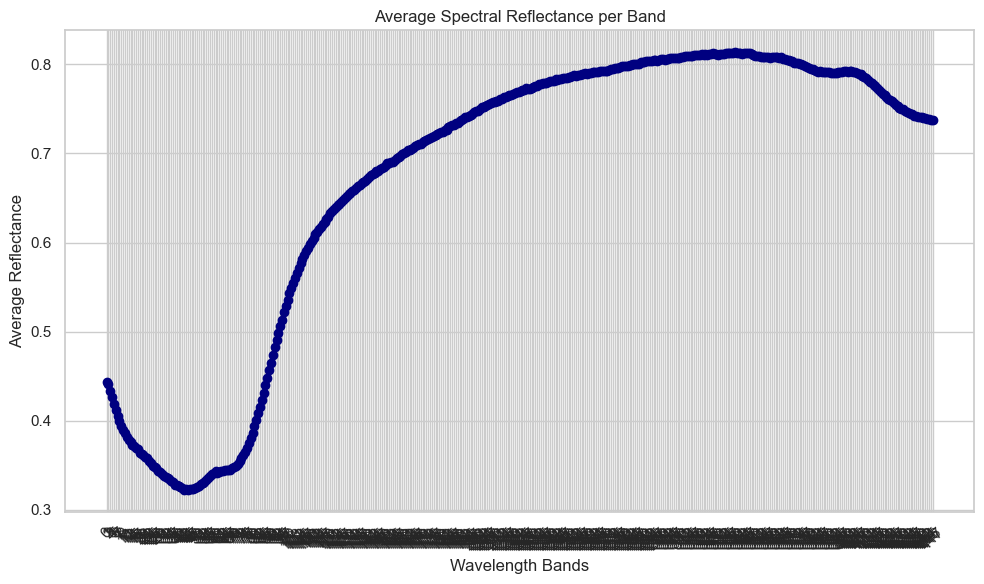

In [82]:
def visualize_data(X, feature_cols):
    # Plot the average reflectance for each spectral band
    avg_reflectance = np.mean(X, axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(feature_cols, avg_reflectance, marker='o', color='navy')
    plt.xlabel("Wavelength Bands")
    plt.ylabel("Average Reflectance")
    plt.title("Average Spectral Reflectance per Band")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
visualize_data(X, feature_cols)

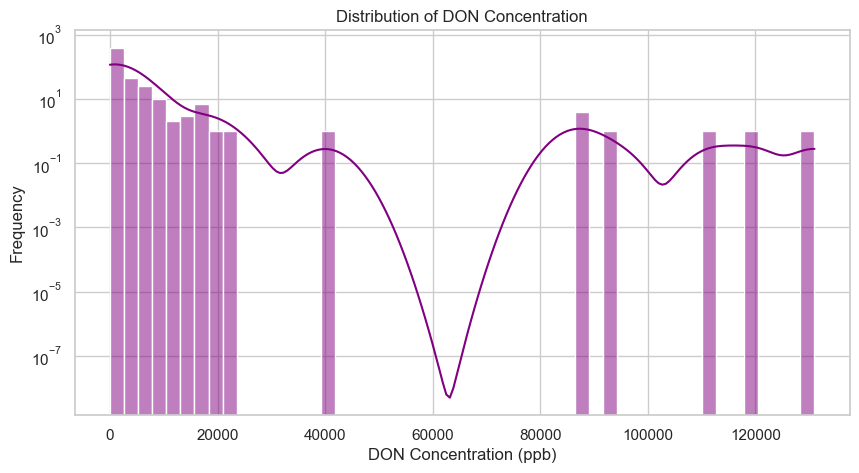

In [83]:
# Plot Distribution of Target Variable
plt.figure(figsize=(10, 5))
sns.histplot(y, bins=50, kde=True, color="purple")
plt.xlabel("DON Concentration (ppb)")
plt.ylabel("Frequency")
plt.title("Distribution of DON Concentration")
plt.yscale("log")  # Log scale to visualize skewed data
plt.show()

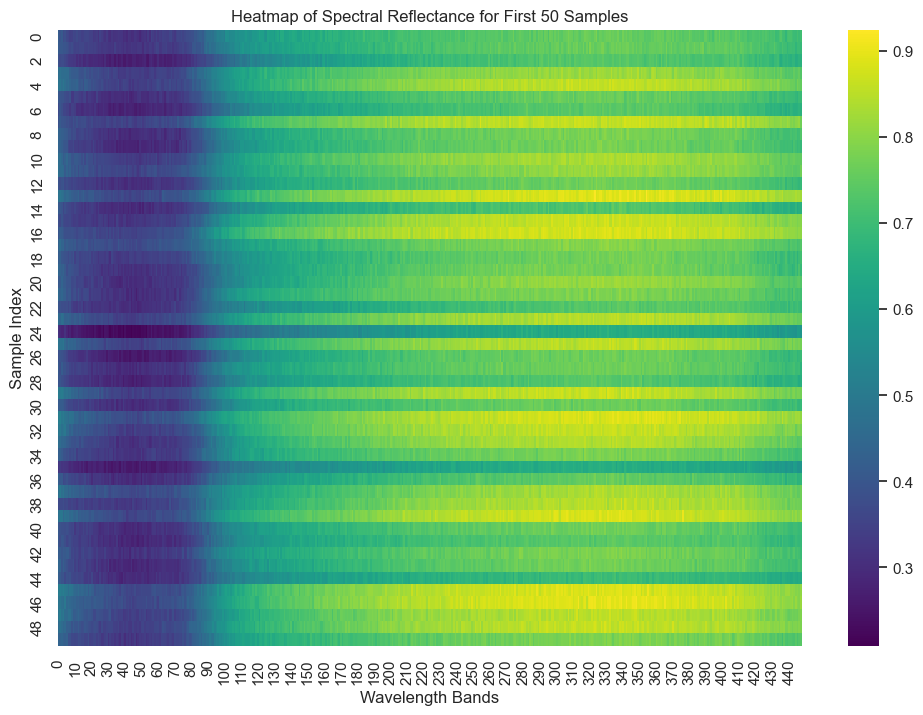

In [84]:
# Heatmap for the first 50 samples
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X, columns=feature_cols).iloc[:50], cmap="viridis")
plt.title("Heatmap of Spectral Reflectance for First 50 Samples")
plt.xlabel("Wavelength Bands")
plt.ylabel("Sample Index")
plt.show()

## Dimensionality Reduction with PCA
- Reduce the feature dimensions using PCA
- Display the explained variance for the top components
- Visualize the data in a 2D scatter plot.


Explained variance ratio for the top 10 components:
PC1: 87.08%
PC2: 5.85%
PC3: 2.11%
PC4: 1.13%
PC5: 0.22%
PC6: 0.08%
PC7: 0.05%
PC8: 0.04%
PC9: 0.04%
PC10: 0.04%


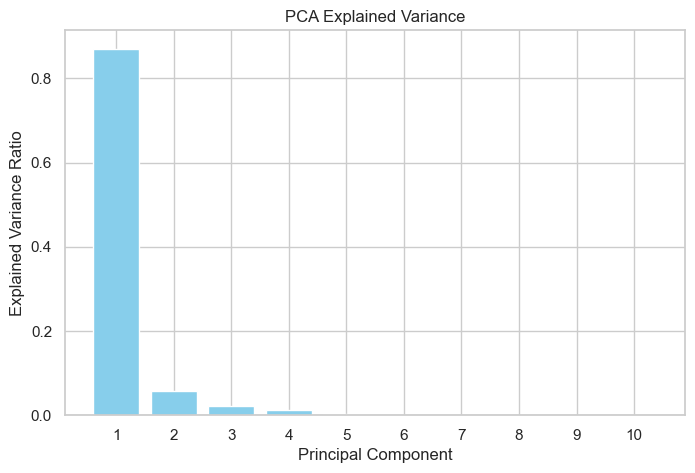

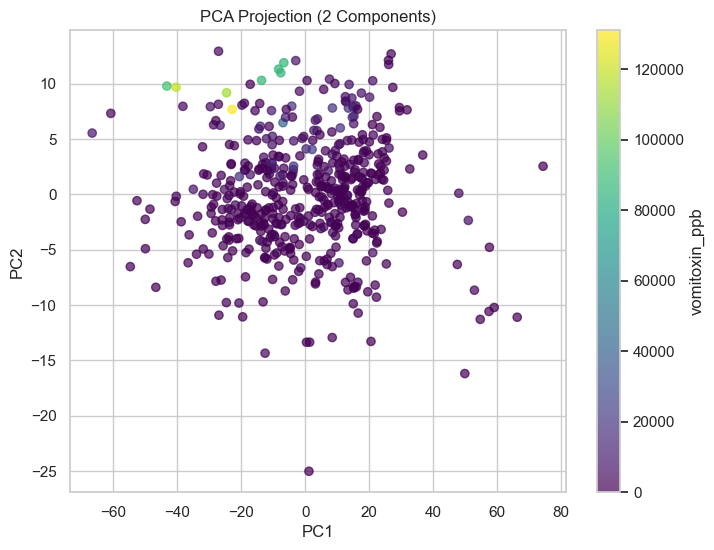

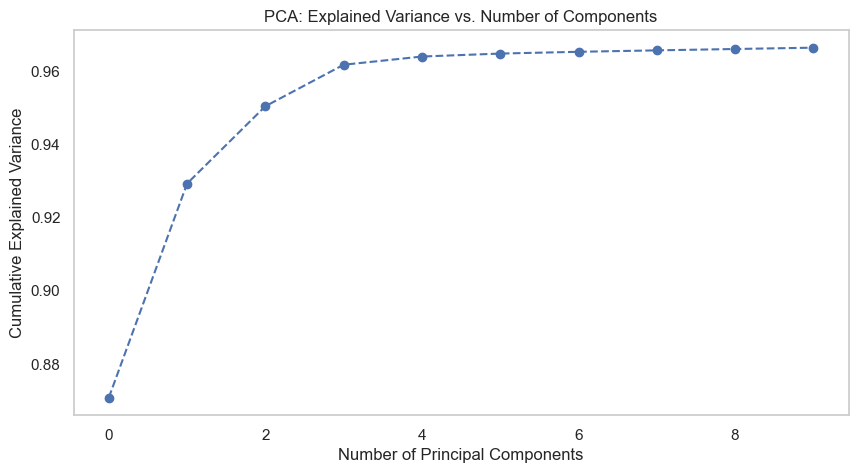

In [85]:
def perform_pca(X_scaled, y, target_col, n_components=10):
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    
    print("\nExplained variance ratio for the top {} components:".format(n_components))
    for i, var in enumerate(explained_variance, start=1):
        print("PC{}: {:.2f}%".format(i, var * 100))
    
    # Bar plot for explained variance
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, n_components + 1), explained_variance, color='skyblue')
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("PCA Explained Variance")
    plt.xticks(range(1, n_components + 1))
    plt.show()
    
    # 2D Scatter plot using the first two principal components
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Projection (2 Components)")
    cbar = plt.colorbar(sc)
    cbar.set_label(target_col)
    plt.show()
    
    return X_pca

# Run PCA
X_pca = perform_pca(X_scaled, y, target_col, n_components=10)

# Variance Explained Plot
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance vs. Number of Components")
plt.grid()
plt.show()


## Model Training:
 1) Feed-Forward Neural Network (Baseline)
 - A simple feed-forward neural network is built, trained, and evaluated for regression.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,961 (128.75 KB)

 Trainable params: 32,961 (128.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 310410368.0000 - mae: 4462.5190 - val_loss: 203181424.0000 - val_mae: 4084.2910
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 262593360.0000 - mae: 3967.0916 - val_loss: 203112640.0000 - val_mae: 4077.7551
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 80252936.0000 - mae: 2568.1833 - val_loss: 203001504.0000 - val_mae: 4067.3684
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 82235512.0000 - mae: 2374.6011 - val_loss: 202832848.0000 - val_mae: 4051.2524
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 156566864.0000 - mae: 3029.7627 - val_loss: 202606832.0000 - val_mae: 4031.0625
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 217778816.0000 - mae: 3403.9849 - val_loss: 202293072.0000 - val_mae: 4012.2642
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 194879760.0000 - mae: 3146.0820 - val_loss: 201894512.0000 - val_mae: 3994.3438
Epoch 8/100
10/10 ━━━━

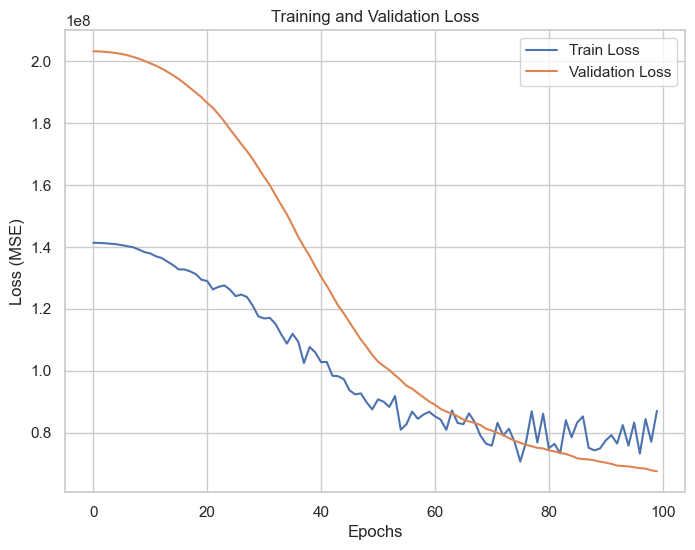


Test MAE: 3582.8545
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Feed-Forward NN Model Evaluation Metrics:
MAE: 3582.8541, RMSE: 10821.5757, R2: 0.5811


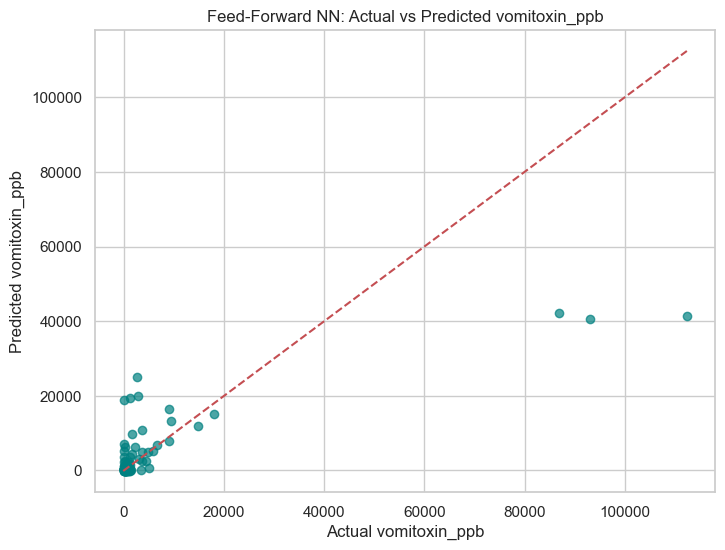

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_model(input_dim):
    # Build a simple neural network for regression
    model = Sequential([
    Input(shape=(input_dim,)),  # Explicitly defining input shape
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
   ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def train_and_evaluate(X_scaled, y, target_col):
    # Split dataset into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Build and summarize the model
    model = build_model(X_train.shape[1])
    model.summary()
    
    # Train the model with early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=32, 
                        validation_split=0.2, 
                        callbacks=[early_stop], 
                        verbose=1)
    
    # Plot training history
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
    # Evaluate the model on the test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print("\nTest MAE: {:.4f}".format(test_mae))
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("\nFeed-Forward NN Model Evaluation Metrics:")
    print("MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(mae, rmse, r2))
    
    # Scatter plot: Actual vs. Predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
    plt.xlabel("Actual " + target_col)
    plt.ylabel("Predicted " + target_col)
    plt.title("Feed-Forward NN: Actual vs Predicted " + target_col)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.show()

# Run the training and evaluation
train_and_evaluate(X_scaled, y, target_col)


2) 1D CNN
- Here we reshape the data as a sequence (each spectral band is a time step) and build a 1D CNN for regression.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 446, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 223, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 221, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 110, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7040)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         450,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 457,025 (1.74 MB)

 Trainable params: 457,025 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 59780344.0000 - mae: 2151.1741 - val_loss: 202975216.0000 - val_mae: 4070.0137
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 116809000.0000 - mae: 2910.2993 - val_loss: 202288736.0000 - val_mae: 4020.9224
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 110378616.0000 - mae: 2851.5691 - val_loss: 200795856.0000 - val_mae: 3962.6616
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 192433472.0000 - mae: 3212.1138 - val_loss: 197988704.0000 - val_mae: 3936.4141
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 86413744.0000 - mae: 2486.2981 - val_loss: 194647424.0000 - val_mae: 4035.1772
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 99427096.0000 - mae: 2964.9917 - val_loss: 191513440.0000 - val_mae: 4220.7954
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 58591168.0000 - mae: 2829.3828 - val_loss: 189924992.0000 - val_mae: 4292.2427
Epoch 8/100
10/10 ━━━━━━

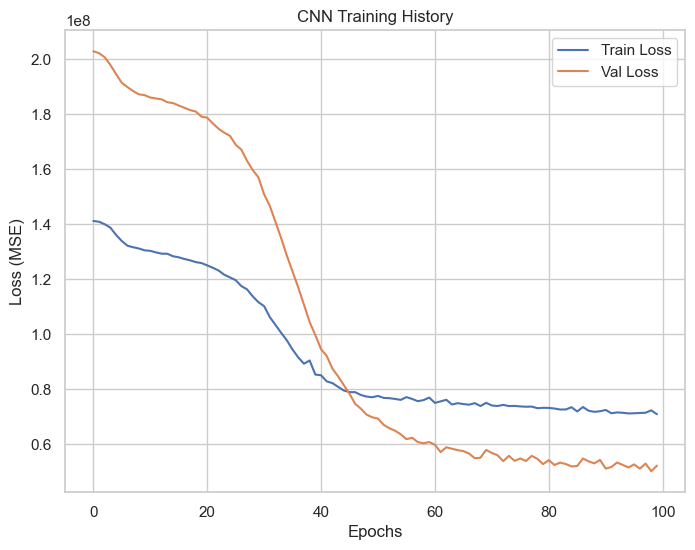


CNN Model Test MAE: 3220.6653
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

CNN Model Evaluation Metrics:
MAE: 3220.6654, RMSE: 9036.4681, R2: 0.7079


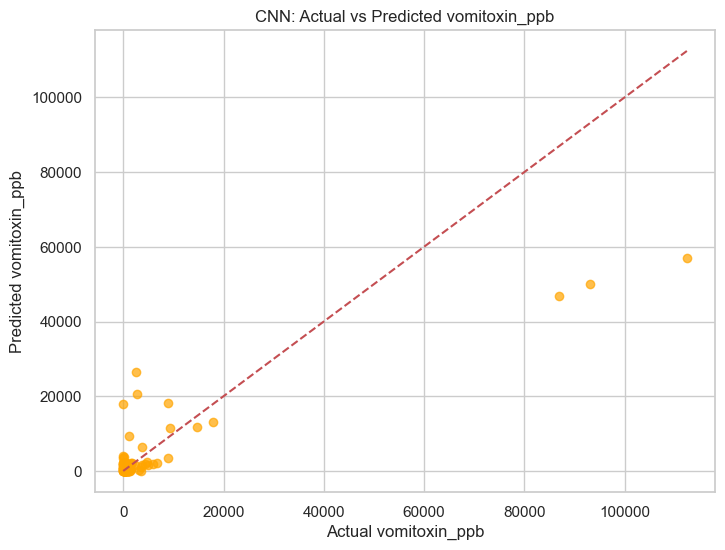

In [21]:
def train_cnn_model(X_scaled, y, target_col):
    # Reshape X for CNN: (samples, features, channels)
    X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)
    
    model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Define input explicitly
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                        callbacks=[early_stop], verbose=1)
    
    # Plot training history
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("CNN Training History")
    plt.legend()
    plt.show()
    
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print("\nCNN Model Test MAE: {:.4f}".format(test_mae))
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("\nCNN Model Evaluation Metrics:")
    print("MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(mae, rmse, r2))
    
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
    plt.xlabel("Actual " + target_col)
    plt.ylabel("Predicted " + target_col)
    plt.title("CNN: Actual vs Predicted " + target_col)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.show()

train_cnn_model(X_scaled, y, target_col)

3) LSTM
- For the LSTM approach, we also reshape the data as a sequence and build a model using LSTM layers.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 448, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 446ms/step - loss: 79875056.0000 - mae: 2502.2424 - val_loss: 203236816.0000 - val_mae: 4088.8628
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - loss: 84527360.0000 - mae: 2514.7063 - val_loss: 203227472.0000 - val_mae: 4088.3394
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - loss: 97152080.0000 - mae: 2444.6958 - val_loss: 203215056.0000 - val_mae: 4087.4675
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - loss: 199129376.0000 - mae: 3255.2385 - val_loss: 203204400.0000 - val_mae: 4086.5996
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step - loss: 185637168.0000 - mae: 2987.2725 - val_loss: 203196640.0000 - val_mae: 4086.0730
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - loss: 88633472.0000 - mae: 2469.1096 - val_loss: 203190672.0000 - val_mae: 4085.6692
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 419ms/step - loss: 171009872.0000 - mae: 3230.6755 - val_loss: 203185120.0000 - val_mae: 4085.2930
Epoch 8/100
10/10

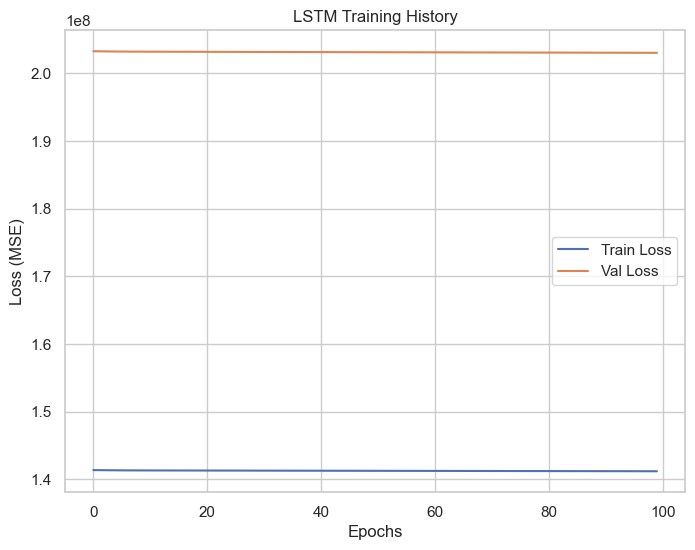


LSTM Model Test MAE: 4393.5405
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000014EA9E0AB90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step

LSTM Model Evaluation Metrics:
MAE: 4393.5404, RMSE: 17284.4912, R2: -0.0688


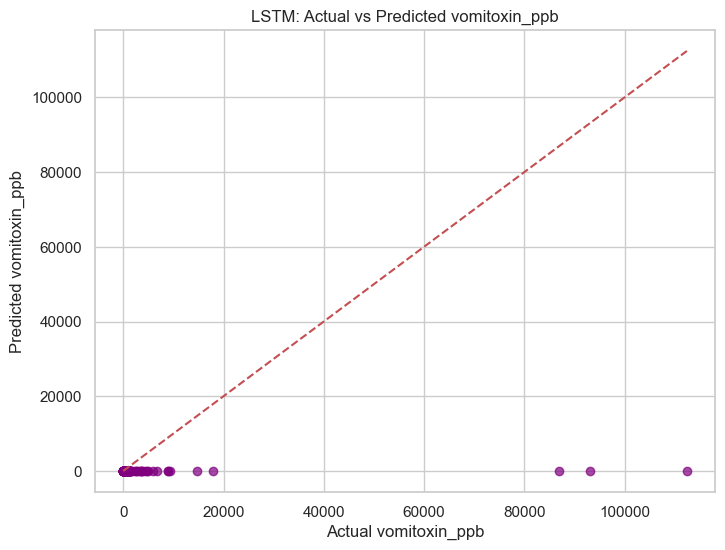

In [37]:
def train_lstm_model(X_scaled, y, target_col):
    # Reshape X for LSTM: (samples, timesteps, features)
    X_lstm = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

    model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Define input explicitly
    LSTM(50, activation='tanh', return_sequences=True),
    LSTM(25, activation='tanh'),
    Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                        callbacks=[early_stop], verbose=1)
    
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("LSTM Training History")
    plt.legend()
    plt.show()
    
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print("\nLSTM Model Test MAE: {:.4f}".format(test_mae))
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("\nLSTM Model Evaluation Metrics:")
    print("MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(mae, rmse, r2))
    
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='purple')
    plt.xlabel("Actual " + target_col)
    plt.ylabel("Predicted " + target_col)
    plt.title("LSTM: Actual vs Predicted " + target_col)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.show()

train_lstm_model(X_scaled, y, target_col)

4) XGBoost
- Using the XGBoost regressor for predicting DON concentration.

XGBoost Model Evaluation Metrics:
MAE: 3972.9279, RMSE: 12996.2889, R2: 0.3958


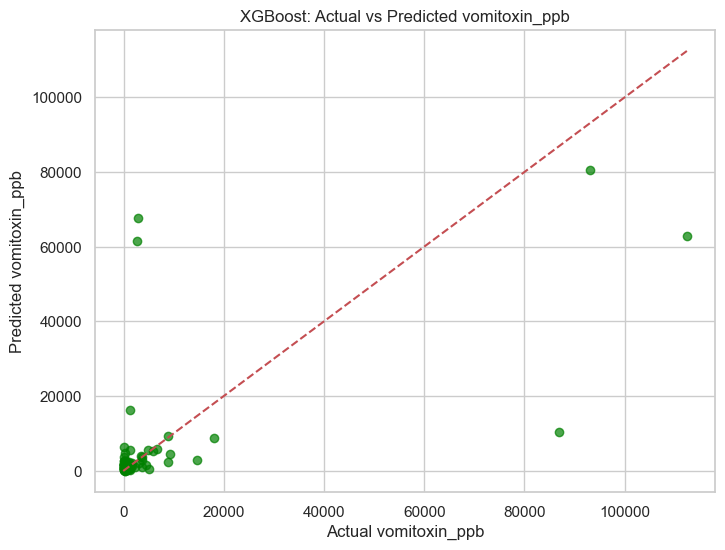

In [38]:
def train_xgboost_model(X_scaled, y, target_col):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("XGBoost Model Evaluation Metrics:")
    print("MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(mae, rmse, r2))
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='green')
    plt.xlabel("Actual " + target_col)
    plt.ylabel("Predicted " + target_col)
    plt.title("XGBoost: Actual vs Predicted " + target_col)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.show()

train_xgboost_model(X_scaled, y, target_col)

5) Graph Neural Network (GNN) using Spektral
- For the GNN approach, we construct a k-nearest neighbor graph from the samples and apply two GCNConv layers. This treats each sample as a node in a graph and performs node regression. 

In [91]:
 def train_gnn_model(X_train_scaled, y_train, target_col, k=10, epochs=200, batch_size=32):
    """
    Trains a Graph Neural Network using Spektral with proper adjacency matrix handling.
    """
    # Construct adjacency matrix
    A = kneighbors_graph(X_train_scaled, k, mode='connectivity', include_self=True).astype('float32')
    A = A.toarray()  # Convert sparse adjacency matrix to dense
    n_nodes, n_features = X_train_scaled.shape
    # Define model
    X_in = Input(shape=(n_features,))
    A_in = Input(shape=(n_nodes, n_nodes))  # Fixed input shape for adjacency matrix
    x = GCNConv(32, activation='relu')([X_in, A_in])
    x = GCNConv(16, activation='relu')([x, A_in])
    output = Dense(1, activation='linear')(x)
    model = Model(inputs=[X_in, A_in], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    # Train model with adjusted batch size
    history = model.fit([X_train_scaled, A], y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
    # Plot training history
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("GNN Training History")
    plt.legend()
    plt.show()
    # Model Evaluation
    y_pred = model.predict([X_train_scaled, A])
    mae = mean_absolute_error(y_train, y_pred)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    r2 = r2_score(y_train, y_pred)
    print("\nGNN Model Evaluation Metrics:")
    print("MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(mae, rmse, r2))
    # Scatter plot: Actual vs Predicted
    plt.figure(figsize=(8,6))
    plt.scatter(y_train, y_pred, alpha=0.7, color='blue')
    plt.xlabel("Actual " + target_col)
    plt.ylabel("Predicted " + target_col)
    plt.title("GNN: Actual vs Predicted " + target_col)
    min_val = min(y_train.min(), y_pred.min())
    max_val = max(y_train.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.show()
    return model

## Summary

In this notebook, we have:

- **Preprocessed and visualized** hyperspectral data from corn samples.
- Applied **PCA** to reduce dimensionality and interpret the spectral data.
- Built and evaluated several regression models including:
  - A basic Feed-Forward Neural Network
  - A 1D CNN
  - An LSTM network
  - An XGBoost regressor
  - A GNN using Spektral

Each approach outputs standard regression metrics and plots to compare actual vs. predicted DON concentrations. 